# 1. Motivation

The project is based on Amazon food data which consists of two datasets: product metadata and product reviews. The datasets we chose to work contain both Amazon product reviews and also metadata about each product, such as product name, product category, and related products. The two datasets supplement each other well, since one contains information about the reviewers of products, and the other contains information about the product that is being reviewed.

We thought it would be interesting to analyse the sentiment of Amazon food reviews, since reviews often are highly subjective yet descriptive. Furthermore, we would like to model the activity of Amazon users (those that write reviews) and try to identify the so-called "super users" that highly active and write many reviews using network science tools. 

Finally, we model the related product recommendations as a network to investigate if a product of one category tends to recommend another product of the similar category.

All in all we want the user to gain a new perspective on user reviews and product recommendations. 

# 2. Basic stats

## Loading data

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import json
import gzip
import networkx as nx
import netwulf as nw
from scipy import stats

In [2]:
# Taken from http://jmcauley.ucsd.edu/data/amazon/links.html

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def parse2(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF2(path):
    i = 0
    df = {}
    for d in parse2(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

Below, we load the review dataset into a pandas dataframe. The dataset consists of product reviews and metadata of products in the "Grocery and Gourmet Food" category on Amazon and was collected by researchers at UCSD.

The original reviews dataset has 142.8 million reviews spanning from May 1996 - July 2014. However, we use only use a subset of the dataset where all users and items have at least 5 reviews in the "Grocery and Gourmet Food" category, called food 5-core. The food 5-core dataset is 108 MB and contains 151,254 reviews, with each review having 9 attributes:

- <code>reviewerID</code> - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- <code>asin </code> - ID of the product, e.g. 0000013714
- <code>reviewerName </code> - name of the reviewer
- <code>helpful </code> - helpfulness rating of the review, e.g. 2/3
- <code>reviewText </code> - text of the review
- <code>overall </code> - rating of the product
- <code>summary </code> - summary of the review
- <code>unixReviewTime </code> - time of the review (unix time)
- <code>reviewTime </code> - time of the review (raw)

In [3]:
# load review data
review_df = getDF('data/reviews_Grocery_and_Gourmet_Food_5.json.gz')
review_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"
...,...,...,...,...,...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,"randomartco ""period film aficionado""","[0, 0]",Delicious gluten-free oatmeal: we tried both t...,4.0,Delicious gluten-free oatmeal 'quick' packs!,1405123200,"07 12, 2014"
151250,AFJFXN42RZ3G2,B00KCJRVO2,"R. DelParto ""Rose2""","[0, 0]",With the many selections of instant oatmeal ce...,4.0,Convenient and Instant,1404604800,"07 6, 2014"
151251,ASEBX8TBYWQWA,B00KCJRVO2,"Steven I. Ramm ""Steve Ramm &#34;Anything Phon...","[1, 1]","While I usually review CDs and DVDs, as well a...",5.0,Compares favorably in taste and texture with o...,1404172800,"07 1, 2014"
151252,ANKQGTXHREOI5,B00KCJRVO2,Titanium Lili,"[0, 1]",My son and I enjoyed these oatmeal packets. H...,4.0,Pretty good!,1404432000,"07 4, 2014"


Below, we load the metadata dataset into a pandas dataframe. The metadata dataset contains metadata for 171,761 products in the "Gorcery and Gourmet Food" category and is 182 MB. Each product has 9 attributes:

- <code>asin </code> - ID of the product, e.g. 0000031852
- <code>title </code> - name of the product
- <code>price </code> - price in US dollars (at time of crawl)
- <code>imUrl </code> - url of the product image
- <code>related </code> - related products (also bought, also viewed, bought together, buy after viewing)
- <code>salesRank </code> - sales rank information
- <code>brand </code> - brand name
- <code>categories </code> - list of categories the product belongs to

In [4]:
# product data
product_df = getDF2('data/meta_Grocery_and_Gourmet_Food.json.gz')
product_df

,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0657745316,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,http://ecx.images-amazon.com/images/I/41gFi5h0...,{'also_viewed': ['B001GE8N4Y']},{'Grocery & Gourmet Food': 374004},[[Grocery & Gourmet Food]],NaN,NaN
1,0700026444,"Silverpot Tea, Pure Darjeeling, is an exquisit...",Pure Darjeeling Tea: Loose Leaf,http://ecx.images-amazon.com/images/I/51hs8sox...,NaN,{'Grocery & Gourmet Food': 620307},[[Grocery & Gourmet Food]],NaN,NaN
2,1403796890,Must have for any WWE Fan\n \n \n \nFeaturing ...,WWE Kids Todler Velvet Slippers featuring John...,http://ecx.images-amazon.com/images/I/518SEST5...,NaN,NaN,[[Grocery & Gourmet Food]],3.99,NaN
3,141278509X,Infused with Vitamins and Electrolytes Good So...,Archer Farms Strawberry Dragonfruit Drink Mix ...,http://ecx.images-amazon.com/images/I/51CFQIis...,{'also_viewed': ['B0051IETTY']},{'Grocery & Gourmet Food': 620322},[[Grocery & Gourmet Food]],NaN,NaN
4,1453060375,MiO Energy is your portable energy source givi...,Mio Energy Liquid Water Enhancer Black Cherry ...,http://ecx.images-amazon.com/images/I/51EUsMcn...,"{'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...",{'Grocery & Gourmet Food': 268754},[[Grocery & Gourmet Food]],11.99,Mio
...,...,...,...,...,...,...,...,...,...
171755,B00LDXFI6Y,Nescafe Cafe Viet is extracted from the aromat...,Nescafe Cafe Viet Vietnamese Sweetened Instant...,http://ecx.images-amazon.com/images/I/51qAGS7j...,{'also_viewed': ['B000DN8EZW']},NaN,[[Grocery & Gourmet Food]],17.99,NaN
171756,B00LMMLRG6,Moon Cheese Snacks Moon Cheese High in protein...,"Moon Cheese, 2 Oz. Pack of Three (Assortment)",http://ecx.images-amazon.com/images/I/419FO438...,{'also_viewed': ['B000UPFWW6']},{'Grocery & Gourmet Food': 54090},[[Grocery & Gourmet Food]],16.95,NaN
171757,B00LOXAZ1Q,Sour Punch candy is the brand of mouth waterin...,"Sour Punch Blue Raspberry Bite, 5 Ounce Bag --...",http://ecx.images-amazon.com/images/I/31Cj3cHD...,NaN,{'Grocery & Gourmet Food': 133517},[[Grocery & Gourmet Food]],16.55,NaN
171758,B00LOZ7F0S,"Our Vanilla Extract made from\nPremium, Organi...",Organic Mexican Vanilla,http://ecx.images-amazon.com/images/I/11iORwy7...,NaN,NaN,[[Grocery & Gourmet Food]],NaN,NaN


### Review network

In the review network, the nodes are reviewers and there is an edge between nodes if they have reviewed the same product. It is an undirected, weighted graph. In order to build the network, all unique products in the review dataframe are found. For each unique product, all users who have reviewed that product are found, and edges are established between them.

In [5]:
review_dict = {}
products = np.unique(list(review_df['asin']))

for product in products:
    reviewers = list(review_df[review_df['asin'] == product]['reviewerID'])
    review_dict[product] = reviewers

Due to the sheer size of the network, it is infeasible to visualise the whole network. Therefore, we make a subset consisting of 500 randomly sampled products and construct a network using the reviewers that have reviewed the subset products. The code below does that.

In [6]:
# code for sampling 500 random products.

# import random

# # 500 random products
# review_dict = {}
# random.seed(19)
# products = np.unique(list(review_df['asin']))
# products = random.sample(list(products), 500)

# for product in products:
#     reviewers = list(review_df[review_df['asin'] == product]['reviewerID'])
#     review_dict[product] = reviewers

Create edges for the undirected network and remove duplicates.

In [7]:
edges = []

for key in review_dict.keys():
    reviewers = review_dict[key]
    for i in range(len(reviewers)):
        node1 = reviewers[i]
        for j in range(i+1, len(reviewers)):
            node2 = reviewers[j]
            edges.append(tuple([node1, node2]))
                
#     break

In [8]:
from_ = [edge[0] for edge in edges]
to_ = [edge[1] for edge in edges]
df = pd.DataFrame()
df['from'] = from_
df['to'] = to_
df2 = df.drop_duplicates()
df2

,from,to
0,A1VEELTKS8NLZB,A14R9XMZVJ6INB
1,A1VEELTKS8NLZB,A27IQHDZFQFNGG
2,A1VEELTKS8NLZB,A31QY5TASILE89
3,A1VEELTKS8NLZB,A2LWK003FFMCI5
4,A1VEELTKS8NLZB,A1NZJTY0BAA2SK
...,...,...
6247888,A3RJR9UL7HEROC,ANKQGTXHREOI5
6247893,A3VYKXHQDICC6,ANKQGTXHREOI5
6247899,AFJFXN42RZ3G2,ASEBX8TBYWQWA
6247902,ASEBX8TBYWQWA,ANKQGTXHREOI5


In [9]:
a = df2.groupby(['from', 'to']).count()
links = list(a.index)

In [10]:
# Find duplicate edges. Since the graph is undirected the edge (a,b) is the same as (b,a)

edge_dict = {}
for (f,t) in links:
    add = True
    if (f,t) not in edge_dict.keys():
        edge_dict[(f,t)] = 0
        if (t,f) in edge_dict.keys():
            edge_dict.pop((f,t))
            edge_dict[(t,f)] += 1
            add = False
    if add:
        edge_dict[(f,t)] += 1
    

Create the reviewer network.

In [12]:
# import networkx as nx
G = nx.Graph()
# G.add_nodes_from(nodes)
G.add_nodes_from(list(np.unique(from_+to_)))

weighted_edges = [(f,t,w) for ((f,t),w) in zip(edge_dict.keys(), edge_dict.values())]
G.add_weighted_edges_from(weighted_edges)

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print(f"The network graph contains {n_nodes} nodes")
print(f"The network graph contains {n_edges} edges")
# density
L_max = n_nodes * (n_nodes - 1)
density = n_edges / L_max
print("network density is: {:2f}".format(density))

The network graph contains 14681 nodes
The network graph contains 4228404 edges
network density is: 0.019620


We can now visualise the network using netwulf.

In [ ]:
# plot the network

import netwulf as nw
stylized_network, config = nw.visualize(G, plot_in_cell_below=False)

In [ ]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

Due to the size of the network, it is only visualised with a subset of reviewers that have reviewed the 500 randomly sampled products. The graph of the subset contains $5773$ nodes and $229767$ edges.

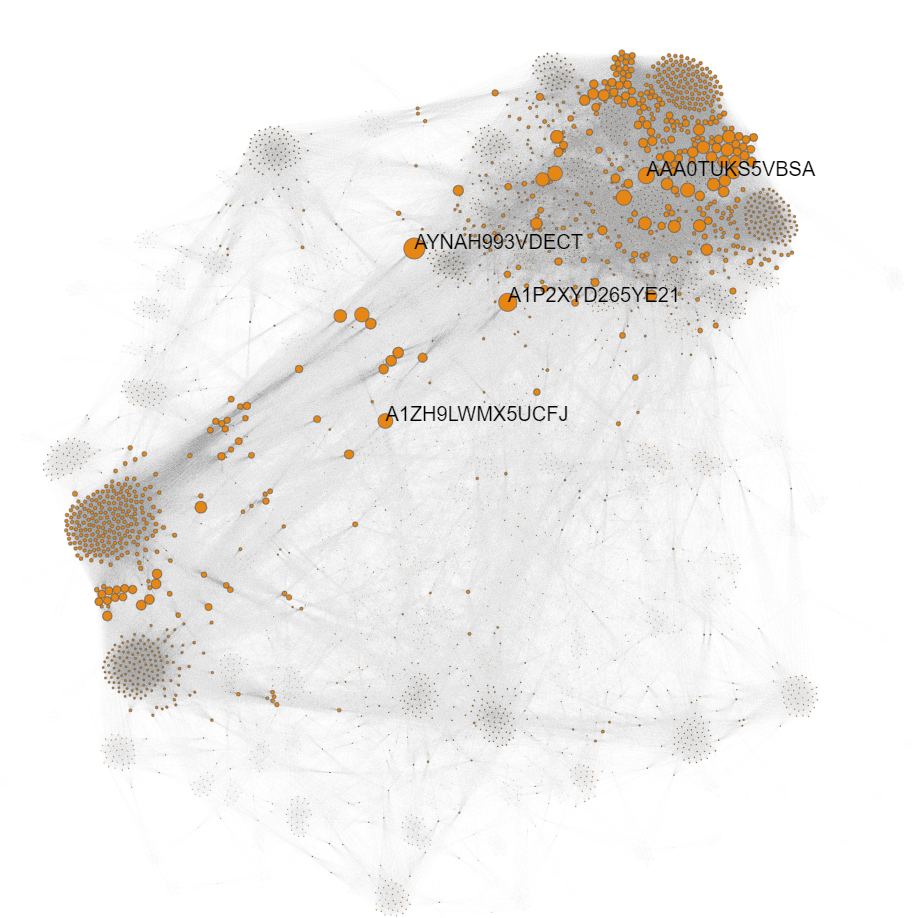

Culprits (with highest node degree):
- A1ZH9LWMX5UCFJ
- AYNAH993VDECT
- A1P2XYD265YE21
- AAA0TUKS5VBSA

## Product network

In order to tie our text and network analysis better together, we remove all products in the product dataframe that are not also in the review dataframe. 

In [31]:
asin_review_list = np.unique(list(review_df['asin']))

count = 0
related_products = []
rel = {}
idx = []
# loop over all products in product_df
for i in range(len(product_df)):
    asin = product_df.iloc[i]['asin']
    
    # if product is in the review df, find its related products.
    if asin in asin_review_list:
        related = product_df.iloc[i]['related']
        
        # check that the product has related items
        if str(related) != "nan":
            related_prod = []
            
            # loop over every key: also viewed, also bought, etc.
            for key in related.keys():
                # check that every related product is also in review_df
                for prod in related[key]:
                    if prod in asin_review_list:
                        related_prod.append(prod)
            rel[i] = related_prod
            related_products.append(related_prod)
        else:
            idx.append(i)
    
    else:
        idx.append(i)

In [32]:
# remove indices in original df
product_df2 = product_df.drop(idx)
product_df2.to_csv("data/product_df2.csv", index=False)
# make a new column 
product_df3 = product_df2.assign(related_products = related_products)
# explode column related_products
product_df3 = product_df3.explode('related_products')
product_df3.to_csv("data/product_df3.csv", index=False)

In [33]:
product_df3 = pd.read_csv("data/product_df3.csv")
product_df3

,asin,description,title,imUrl,related,salesRank,categories,price,brand,related_products
0,616719923X,Green Tea Flavor Kit Kat have quickly become t...,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,http://ecx.images-amazon.com/images/I/51LdEao6...,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",{'Grocery & Gourmet Food': 37305},[['Grocery & Gourmet Food']],NaN,NaN,B0047YG5UY
1,616719923X,Green Tea Flavor Kit Kat have quickly become t...,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,http://ecx.images-amazon.com/images/I/51LdEao6...,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",{'Grocery & Gourmet Food': 37305},[['Grocery & Gourmet Food']],NaN,NaN,B0002IZD02
2,616719923X,Green Tea Flavor Kit Kat have quickly become t...,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,http://ecx.images-amazon.com/images/I/51LdEao6...,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",{'Grocery & Gourmet Food': 37305},[['Grocery & Gourmet Food']],NaN,NaN,B004N8LMFM
3,616719923X,Green Tea Flavor Kit Kat have quickly become t...,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,http://ecx.images-amazon.com/images/I/51LdEao6...,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",{'Grocery & Gourmet Food': 37305},[['Grocery & Gourmet Food']],NaN,NaN,B0009F8JRC
4,616719923X,Green Tea Flavor Kit Kat have quickly become t...,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,http://ecx.images-amazon.com/images/I/51LdEao6...,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",{'Grocery & Gourmet Food': 37305},[['Grocery & Gourmet Food']],NaN,NaN,B004HU7TC6
...,...,...,...,...,...,...,...,...,...,...
380298,B00K00H9I6,Harvested from the iconic snowy woods of Quebe...,Canadian Finest Maple Syrup - 100% Pure Certif...,http://ecx.images-amazon.com/images/I/41abh7Ho...,"{'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...",{'Grocery & Gourmet Food': 1500},[['Grocery & Gourmet Food']],18.95,NaN,B008RVURA2
380299,B00K00H9I6,Harvested from the iconic snowy woods of Quebe...,Canadian Finest Maple Syrup - 100% Pure Certif...,http://ecx.images-amazon.com/images/I/41abh7Ho...,"{'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...",{'Grocery & Gourmet Food': 1500},[['Grocery & Gourmet Food']],18.95,NaN,B002483TSQ
380300,B00K00H9I6,Harvested from the iconic snowy woods of Quebe...,Canadian Finest Maple Syrup - 100% Pure Certif...,http://ecx.images-amazon.com/images/I/41abh7Ho...,"{'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...",{'Grocery & Gourmet Food': 1500},[['Grocery & Gourmet Food']],18.95,NaN,B000LKXNG2
380301,B00KC0LGI8,NaN,"Betty Crocker Dry Meals Suddenly Grain Salad, ...",http://ecx.images-amazon.com/images/I/61zqxqJi...,"{'also_viewed': ['B00KSKIHVG', 'B00JWWM1T0', '...",{'Grocery & Gourmet Food': 97624},[['Grocery & Gourmet Food']],NaN,NaN,NaN


We are only interested in products that have at least one subcategory other than "Grocery & Gourmet Food", since we want to look at how well these subcategories work as communities. Therefore we remove all products that do not have any subcategories

In [34]:
idx = []
categories = []
categories2 = {}
for i in range(len(product_df3)):
    if str(product_df3.iloc[i]['categories']) == str([['Grocery & Gourmet Food']]):
        idx.append(i)
    else:
        h = product_df3.iloc[i]['categories']
        h = h.replace("[","").replace("]","").replace(" '","").replace("'", "")
        h = h.split(",")
        
        categories2[product_df3['asin'].iloc[i]] = h[1]
        
        categories.append(h[1])
        

In [35]:
# remove indices in original df
product_df4 = product_df3.drop(idx)
# make a new column
product_df5 = product_df4.assign(category=categories)
# explode column related_products
product_df5
product_df5.to_csv("data/product_df5.csv", index=False)

In [36]:
product_df5 = pd.read_csv("data/product_df5.csv")
product_df5

,asin,description,title,imUrl,related,salesRank,categories,price,brand,related_products,category
0,B00004S1C5,"From Easter eggs to colorful cookies, Spectrum...","Ateco Food Coloring Kit, 6 colors",http://ecx.images-amazon.com/images/I/41F75K9F...,"{'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...",{'Kitchen & Dining': 4494},"[['Grocery & Gourmet Food', 'Cooking & Baking'...",9.76,HIC Harold Import Co.,B002PO3KBK,Cooking & Baking
1,B00004S1C5,"From Easter eggs to colorful cookies, Spectrum...","Ateco Food Coloring Kit, 6 colors",http://ecx.images-amazon.com/images/I/41F75K9F...,"{'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...",{'Kitchen & Dining': 4494},"[['Grocery & Gourmet Food', 'Cooking & Baking'...",9.76,HIC Harold Import Co.,B000R4LONQ,Cooking & Baking
2,B00004S1C5,"From Easter eggs to colorful cookies, Spectrum...","Ateco Food Coloring Kit, 6 colors",http://ecx.images-amazon.com/images/I/41F75K9F...,"{'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...",{'Kitchen & Dining': 4494},"[['Grocery & Gourmet Food', 'Cooking & Baking'...",9.76,HIC Harold Import Co.,B007F1MA46,Cooking & Baking
3,B00004S1C5,"From Easter eggs to colorful cookies, Spectrum...","Ateco Food Coloring Kit, 6 colors",http://ecx.images-amazon.com/images/I/41F75K9F...,"{'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...",{'Kitchen & Dining': 4494},"[['Grocery & Gourmet Food', 'Cooking & Baking'...",9.76,HIC Harold Import Co.,B0001M0YK8,Cooking & Baking
4,B00004S1C5,"From Easter eggs to colorful cookies, Spectrum...","Ateco Food Coloring Kit, 6 colors",http://ecx.images-amazon.com/images/I/41F75K9F...,"{'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...",{'Kitchen & Dining': 4494},"[['Grocery & Gourmet Food', 'Cooking & Baking'...",9.76,HIC Harold Import Co.,B0012DMI1S,Cooking & Baking
...,...,...,...,...,...,...,...,...,...,...,...
13541,B00JGPG60I,Enfamil Reguline is an everyday formula that g...,Enfamil Reguline Milk-Based Powder with Iron I...,http://ecx.images-amazon.com/images/I/510zYVQ8...,"{'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...",{'Health & Personal Care': 13464},"[['Grocery & Gourmet Food', 'Baby Foods', 'Bab...",16.00,Enfamil,B0039NMF9E,Baby Foods
13542,B00JGPG60I,Enfamil Reguline is an everyday formula that g...,Enfamil Reguline Milk-Based Powder with Iron I...,http://ecx.images-amazon.com/images/I/510zYVQ8...,"{'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...",{'Health & Personal Care': 13464},"[['Grocery & Gourmet Food', 'Baby Foods', 'Bab...",16.00,Enfamil,B003U9MCQI,Baby Foods
13543,B00JGPG60I,Enfamil Reguline is an everyday formula that g...,Enfamil Reguline Milk-Based Powder with Iron I...,http://ecx.images-amazon.com/images/I/510zYVQ8...,"{'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...",{'Health & Personal Care': 13464},"[['Grocery & Gourmet Food', 'Baby Foods', 'Bab...",16.00,Enfamil,B002IYDXW8,Baby Foods
13544,B00JGPG60I,Enfamil Reguline is an everyday formula that g...,Enfamil Reguline Milk-Based Powder with Iron I...,http://ecx.images-amazon.com/images/I/510zYVQ8...,"{'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...",{'Health & Personal Care': 13464},"[['Grocery & Gourmet Food', 'Baby Foods', 'Bab...",16.00,Enfamil,B000BIUH1I,Baby Foods


We prepare the edges for the product network, after which we can create the initial network: 

In [37]:
edge_dict = {}
nancount = 0
for i in range(len(product_df5)):
    if str(product_df5['related_products'].iloc[i]) != 'nan':
        key_ = tuple([product_df5.iloc[i]['asin'], product_df5.iloc[i]['related_products']])
        if key_ not in edge_dict.keys():
            edge_dict[key_] = 0
        edge_dict[key_] += 1
    else:
        nancount += 1
        
len(edge_dict)

10625

We create a networkx graph which has 358 nodes and 2814 edges. 

In [38]:
edges = edge_dict.keys()

G = nx.Graph()
G.add_nodes_from(product_df5['asin'])
print("Number of nodes in the product network:", len(G.nodes()))
G.add_edges_from(edges)
print("Number of edges in the product network:", len(G.nodes()))

Number of nodes in the product network: 358
Number of edges in the product network: 2814


Because adding the edges added some of the nodes with only the "Grocery & Gourmet food" category that we removed before, we remove them again. Furthermore, each node is given an attribute which corresponds to its category.

In [39]:
G3 = nx.Graph()

temp_df = product_df5.copy()

temp_df.set_index("asin", inplace = True)

G3.add_nodes_from(product_df5['asin'])

for edge in list(G.edges()):
#     print(edge)
    if edge[0] in list(G3.nodes()):
        if edge[1] in list(G3.nodes()):
            G3.add_edge(edge[0],edge[1])

# print(len(G3.nodes()))
cat2 = {}
for node in list(G3.nodes()):
    cat2[node] = np.unique(temp_df['category'].loc[node])[0]

nx.set_node_attributes(G3, cat2, name='category')

Some stats for the product network:

In [40]:
# number of nodes
n_nodes = G3.number_of_nodes()
print("number of nodes:", n_nodes)
# number of edges
n_edges = G3.number_of_edges()
print("number of edges:", n_edges)

# density
L_max = n_nodes * (n_nodes - 1)
density = n_edges / L_max
print("network density: {:2f}".format(density))

number of nodes: 358
number of edges: 1044
network density: 0.008169


In [41]:
# degree
print("mean degree", np.mean([i[1] for i in G3.degree()]))
print("median degree", np.median([i[1] for i in G3.degree()]))
print("mode of degree", stats.mode([i[1] for i in G3.degree()]).mode[0])
print("min degree", np.min([i[1] for i in G3.degree()]))
print("max degree", np.max([i[1] for i in G3.degree()]))

mean degree 5.832402234636872
median degree 5.0
mode of degree 0
min degree 0
max degree 38


We can now visualize the network

In [68]:
network = nw.get_filtered_network(G3, node_group_key="category")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

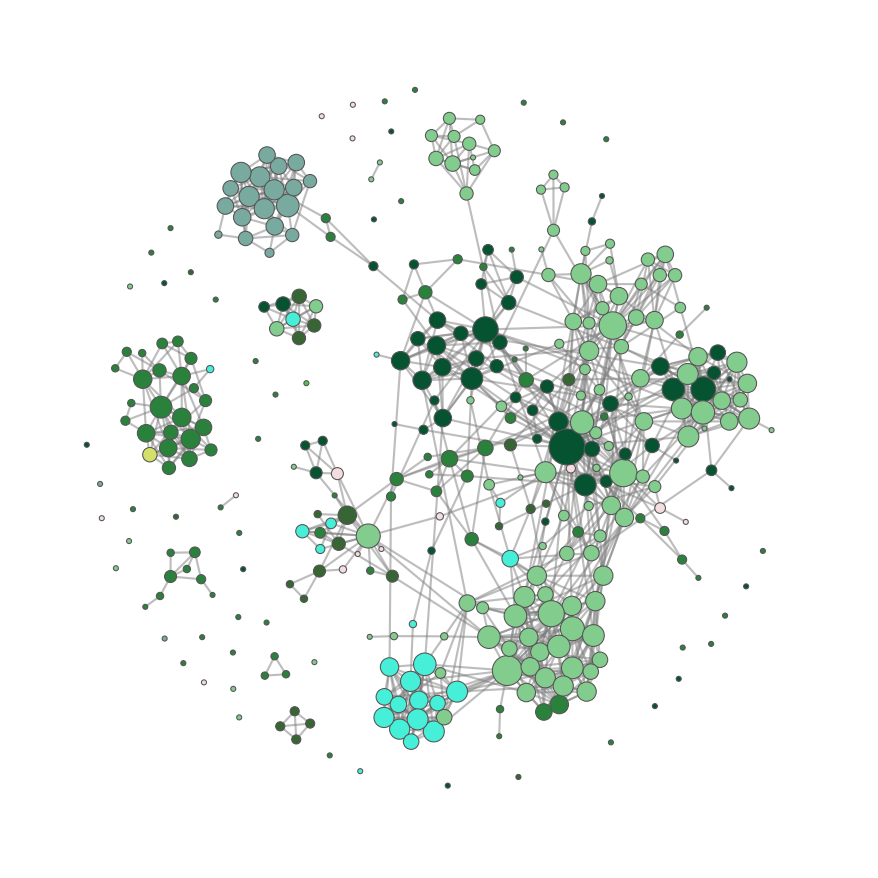

In [69]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

# 3. Tools, theory and analysis

## Review network

In [13]:
# this cell finds the IDs of the products that have been sampled
idxs = []
for i in range(len(products)):
    idx = np.where(review_df['asin'] == products[i])
    idxs.extend(idx[0])

In [14]:
culprits_df = review_df.iloc[idxs]
# find the review for all culprits
culprits = ['A1ZH9LWMX5UCFJ','AYNAH993VDECT', 'A1P2XYD265YE21', 'AAA0TUKS5VBSA']
for culprit in culprits:
    reviews = culprits_df[culprits_df['reviewerID'] == culprit]
    n = len(reviews)
    print("The reviewer name is:", reviews['reviewerName'].iloc[0])
    print("Number of reviews:", n)
    print("Sample review text:", reviews['reviewText'].iloc[np.random.randint(n)])
    print("Node degree in network:", G.degree[culprit])
    print("\n")


The reviewer name is: K. Stuckey "kateling"
Number of reviews: 82
Sample review text: I ordered this item based on the Jamba Juice name and was pretty disappointed. I like tart apples but this is not enjoyable at all. I didn't notice a significant increase in my energy either, I drank it during a break at work. Glad I got to try one for free, not worth the price.
Node degree in network: 3178


The reviewer name is: bsg2004
Number of reviews: 75
Sample review text: If you like to mix and match your coffee sources (all apologies to the coffee-purists out there), then this coffee's ideal use is to add flavor to your regular coffee. For example, if you are making unflavored coffee and want to give it some "flavor", adding a little bit (or more than a little bit depending on your preference) of this can add a different dimension to your otherwise regular coffee. With a smaller amount, this is more subtle, and not as over-powering for people who like some flavor, but not fully-flavored coffe

In [15]:
# let's look at the reviewers with the most reviews in our dataset. 
culprits_df.groupby(['reviewerID']).count().sort_values('asin', ascending=False).iloc[0:10]

,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
reviewerID,,,,,,,,
A3OXHLG6DIBRW8,204,203,204,204,204,204,204,204
AY12DBB0U420B,180,180,180,180,180,180,180,180
A2XKJ1KX6XUHYP,177,177,177,177,177,177,177,177
A1UQBFCERIP7VJ,156,156,156,156,156,156,156,156
AAA0TUKS5VBSA,149,148,149,149,149,149,149,149
A2MNB77YGJ3CN0,145,145,145,145,145,145,145,145
A25C2M3QF9G7OQ,141,140,141,141,141,141,141,141
A1Z54EM24Y40LL,140,140,140,140,140,140,140,140
A2YKWYC3WQJX5J,132,132,132,132,132,132,132,132


In some rows, the numbers do not match up. For example, in row 1 some values are 204, while it is 203 in another. Turns out, sometimes the reviewer name is recorded as 'nan' (not a number) 

In [16]:
np.unique(list(culprits_df[culprits_df['reviewerID'] == 'A3OXHLG6DIBRW8']['reviewerName']))

array(['C. Hill "CFH"', 'nan'], dtype='<U13')

In [17]:
# find reviewer names
reviewerIDs = culprits_df.groupby(['reviewerID']).count().sort_values('asin', ascending=False).iloc[0:10].index
for reviewerID in reviewerIDs:
    print(list(culprits_df[culprits_df['reviewerID'] == reviewerID]['reviewerName'])[0])

C. Hill "CFH"
Gary Peterson
NYFB
Margaret Picky
Nerd Alert
L. Mountford
Comdet
csm
Shannon Lastowski "Queen of Caffeine"
J. Arena


It is worth noting that among the identified users with the highest node degree, only one of them (Nerd Alert) is among the users with the top 10 most reviews. However, keep in mind that the network has an edge between two nodes if they have reviewed the same product. This means if a product has been reviewed by many people, then the users who have reviewed that product will have many edges. 

In [18]:
# add top 3 super users
culprits2 = ['A1ZH9LWMX5UCFJ','AYNAH993VDECT', 'A1P2XYD265YE21', 'AAA0TUKS5VBSA'] + ['A3OXHLG6DIBRW8', 'AY12DBB0U420B', 'A2XKJ1KX6XUHYP']
most_reviewed_products_count = most_reviewed_products = culprits_df.groupby('asin').count().sort_values('reviewerID', ascending=False)

for culprit in culprits2:
    reviewed_products = list(culprits_df[culprits_df['reviewerID'] == culprit]['asin'])
    reviews = culprits_df[culprits_df['reviewerID'] == culprit]
    print("The reviewer name is:", reviews['reviewerName'].iloc[0])
    print("Reviewer:", culprit)
    print("Node degree in network:", G.degree[culprit])
    all_reviews = []
    for reviewed_product in reviewed_products:
        n = int(most_reviewed_products.loc[most_reviewed_products.index == reviewed_product]['reviewerID'])
#         print("The product {} has {} reviews".format(reviewed_product, n))
        all_reviews.append(n)
    print("Average number of reviews per reviewed product:", sum(all_reviews)/len(all_reviews)) # (average review score)
    print('\n')

The reviewer name is: K. Stuckey "kateling"
Reviewer: A1ZH9LWMX5UCFJ
Node degree in network: 3178
Average number of reviews per reviewed product: 74.3780487804878


The reviewer name is: bsg2004
Reviewer: AYNAH993VDECT
Node degree in network: 3701
Average number of reviews per reviewed product: 183.17333333333335


The reviewer name is: Andrea "Readaholic"
Reviewer: A1P2XYD265YE21
Node degree in network: 3629
Average number of reviews per reviewed product: 165.37313432835822


The reviewer name is: Nerd Alert
Reviewer: AAA0TUKS5VBSA
Node degree in network: 4012
Average number of reviews per reviewed product: 126.63087248322148


The reviewer name is: C. Hill "CFH"
Reviewer: A3OXHLG6DIBRW8
Node degree in network: 5155
Average number of reviews per reviewed product: 74.06862745098039


The reviewer name is: Gary Peterson
Reviewer: AY12DBB0U420B
Node degree in network: 2789
Average number of reviews per reviewed product: 20.13888888888889


The reviewer name is: NYFB
Reviewer: A2XKJ1KX6XU

The user with the highest number of reviews and node degree is C. Hill "CFH". However, writing many reviews does not equate to having a high node degree. For instance, the user "Gary Peterson" has written the second most reviews with 180, yet only have a node degree of 2,374. Comparatively, another user, "bsg2004" have only written 75 reviews, but have a much higher node degree of 3,701. Based on the average review score, we see that even though the users "Gary Peterson" and "NYFB" have written many reviews, the products that they review are not commonly reviewed by others. 

In conclusion, the reviewer network can be useful to identify some super users. However, the number of times a product has been reviewed needs to be accounted for, since it has a major impact on the node degree.

### Random network

The reviewer network is an example of a real-world network constructed using real data. We would like to construct a random network that have some of the same properties as the reviewer network, and then compare them. 

Using equation 3.2 from [1], we want to find the probability $p$ that a network with $N$ nodes has <$L$> expected edges:

$$
\begin{equation}
\text{<}L\text{>} = p \cdot \frac{N(N-1)}{2} 
\end{equation}
$$

Since there are $L=229767 = \text{<}L\text{>}$ edges in the network, the probability can be computed as:

$$
\begin{equation}
p = \frac{2\cdot L}{N(N-1)}
\end{equation}
$$

With the found value of $p$, the average degree of the network $\text{<}k\text{>}$ is computed using equation 3.3 in [1]:

$$
\begin{equation}
\text{<}k\text{>} = p(N-1)
\end{equation}
$$

In [19]:
#find p in equation 3.2: N is length of nodes, <L> is length of edges
N = len(G.nodes())
L = len(G.edges())
p = (2*L) / (N*(N-1))
print('p =', p)

# compute average degree using equation 3.3
k = p*(N-1)
print('k =',k)

p = 0.03923961850262633
k = 576.0375996185546


In [20]:
# we can also compute the average degree of G like this.
np.mean(list(dict(G.degree).values()))

576.0375996185546

Now, we build a random network with the same number of nodes as the reviewer network. With the probability $p = 0.039$, an edge is added between node $i$ and $j$.

In [21]:
#Code for generating random network
randomG = nx.Graph()
randomG.add_nodes_from([i for i in range(1,len(G.nodes))])
for i in range(1, len(G.nodes)+1):
    for j in range(i+1, len(G.nodes)+1):
        num = np.random.uniform()
        if num < p:
            randomG.add_edge(i,j)
    if i % 1000 == 0:
        print(f"{i}/{len(G.nodes)+1}")

1000/14682
2000/14682
3000/14682
4000/14682
5000/14682
6000/14682
7000/14682
8000/14682
9000/14682
10000/14682
11000/14682
12000/14682
13000/14682
14000/14682


In [22]:
print(f"The reviewer network contains {G.number_of_nodes()} nodes")
print(f"The reviewer network contains {G.number_of_edges()} edges")

print(f"The random network contains {randomG.number_of_nodes()} nodes")
print(f"The random network contains {randomG.number_of_edges()} edges")

The reviewer network contains 14681 nodes
The reviewer network contains 4228404 edges
The random network contains 14681 nodes
The random network contains 4230386 edges


### Degree distribution

In [23]:
import matplotlib.pyplot as plt
# define bin size using max and min
print(np.min([i[1] for i in G.degree]), np.max([i[1] for i in G.degree])) 

# define bin size using max and min
print(np.min([i[1] for i in randomG.degree]), np.max([i[1] for i in randomG.degree]))

8 5155
480 672


The degree distribution histograms are visualised with linear x-axis and y-axis. We tried with logarithmic axis on both plots, but it made the degree distribution for the reviewer network look Gaussian distributed which is misleading.

### Degree distribution for reviewer network

In [24]:
# bins = np.logspace(0, np.log10(5200), 50) # logarithmic binning
bins = np.linspace(0, 5200, 40) # linear binning
# make histogram
hist, edges = np.histogram([i[1] for i in G.degree], bins=bins, density=True)
# make midpoints and width
x = (edges[1:] + edges[:-1]) / 2
width = bins[1]-bins[0]

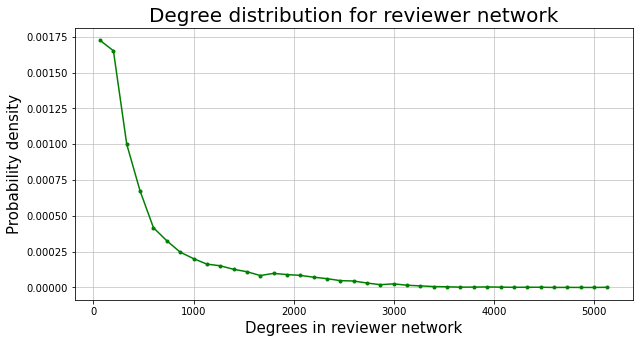

In [25]:
# plot histogram
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(x, hist, marker=".", color='green')
ax.set_xlabel("Degrees in reviewer network", size=15)
ax.set_ylabel("Probability density", size=15)
ax.set_title("Degree distribution for reviewer network", size=20)
ax.grid(alpha=0.7)

### Degree distribution for random network

In [26]:
# bins = np.logspace(np.log10(480), np.log10(680), 50) # logarithmic binning
bins = np.linspace(480, 680, 40) # linear binning
# make histogram
hist, edges = np.histogram([i[1] for i in randomG.degree], bins=bins, density=True)
# make midpoints and width
x = (edges[1:] + edges[:-1]) / 2
width = bins[1]-bins[0]

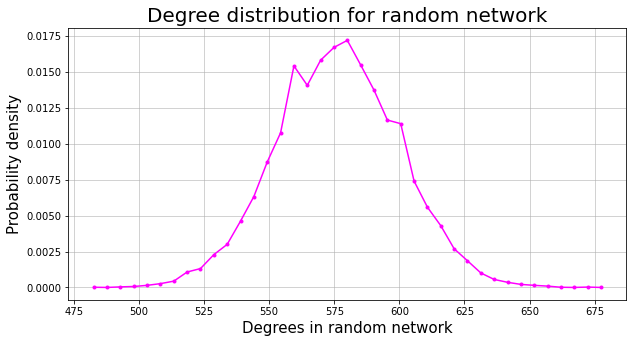

In [27]:
# plot histogram
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(x, hist, marker=".", color='magenta')
ax.set_xlabel("Degrees in random network", size=15)
ax.set_ylabel("Probability density", size=15)
ax.set_title("Degree distribution for random network", size=20)
ax.grid(alpha=0.7)

In [28]:
print("The average degree for the reviewer network is:", np.mean(list(dict(G.degree()).values())))
print("The average degree for the random network is:", np.mean(list(dict(randomG.degree()).values())))

print("The median degree for the reviewer network is:", np.median(list(dict(G.degree()).values())))
print("The median degree for the random network is:", np.median(list(dict(randomG.degree()).values())))

The average degree for the reviewer network is: 576.0375996185546
The average degree for the random network is: 576.3076084735372
The median degree for the reviewer network is: 312.0
The median degree for the random network is: 576.0


Both networks have around the same average degree, but their distributions vary. The degree distribution for the reviewer network is much more spread out, with degrees ranging from 8 to 5155, and skewed towards the left, indicating that smaller degrees are the most frequent. This is reflected in the median degree of the reviewer network, which is much lower than median degree of the random network.

For both networks we can compute the average clustering coefficient, which is a measure of the degree to which nodes tend to cluster together. Using equation 2.15 in [2], the local clustering coefficient for a node $i$ is computed as:
$$
\begin{equation}
C_i = \frac{2\cdot L_i}{k_i(k_i-1)}
\end{equation}
$$
where $L_i$ is the number of edges node $i$ has to its $k_i$ neighbours.

The average clustering coefficient is found by averaging the local clustering coefficient for all nodes. This is computed for both the reviewer network and the random network.

In [29]:
#Compute clustering coefficient using equation 2.15
CClist1 = []
for node in G.nodes():
    K = len(list(nx.neighbors(G,node)))
    L = nx.triangles(G,node)
    if K > 1:
        CClist1.append(2*L/(K*(K-1)))
    elif K == 1:
        CClist1.append(0)
        
print("The average clustering coefficient for the reviewer network is:",np.mean(CClist1))

The average clustering coefficient for the reviewer network is: 0.40487891564180795


In [30]:
#Compute clustering coefficient using equation 2.15
CClist = []
for node in randomG.nodes():
    K = len(list(nx.neighbors(randomG,node)))
    L = nx.triangles(randomG,node)
    if K > 1:
        CClist.append(2*L/(K*(K-1)))
    elif K == 1:
        CClist.append(0)
        
print("The average clustering coefficient for the random network is:",np.mean(CClist))

The average clustering coefficient for the random network is: 0.03925593444716841


We see that the average clustering coefficient is much larger for the reviewer network than the random network with a similar amount of nodes and edges. This is consistent with what is described in [3]: one would expect a real-life network with N nodes and L edges to have much higher clustering coefficients than a random network of similar size.

## Product Network

Here we take a closer look at a few select products, one of each category. Especially the products B009GCXEW4 and B0033HGLTG are interesting since B009GCXEW4 is a lone off-category node on an island mostly consisting of products with the "Beverages" category like B0033HGLTG.

In [42]:
asinlist = ["B000BIUH18","B0033HGLTG","B009GCXEW4","B0000DGF9V","B002R89LOE","B0088W8HKC","B000RL4UNA","B000EITYUU","B00016RH40"]


for asin in asinlist:
    print(asin)
    print(list(temp_df.loc[asin]['category'])[0])
    print('---------')

B000BIUH18
Baby Foods
---------
B0033HGLTG
Beverages
---------
B009GCXEW4
Gourmet Gifts
---------
B0000DGF9V
Fresh Flowers & Live Indoor Plants
---------
B002R89LOE
Breakfast Foods
---------
B0088W8HKC
Snack Foods
---------
B000RL4UNA
Candy & Chocolate
---------
B000EITYUU
Canned
---------
B00016RH40
Cooking & Baking
---------


We now want to look at communities. The communities made from the product categories are a focus of our analysis since we can get insight into how much Amazon tends to recommend products of the same category.

We want to calculate the modalities of the communities defined by the categories. The modality gives us a measure of how good the partition made from the category tags are, and allows us to compare it directly to other partitions, in particular a partition made with the Louvain algorithm. We define a function to calculate the modularity from the equation from the Network sience book: http://networksciencebook.com/chapter/9#modularity

"The modularity is a measure for the quality of the division of a network. A high modularity score means that the given division has divided the network into communities that are strongly interconnected and which does not have many connections outside of the community. The higher the modularity, the better the division is." [4]

In [71]:
def computeModularity(G, partition):

    partitions = np.unique(list(nx.get_node_attributes(G,partition).values()))
    partition_dic = {part: [] for part in partitions}
    
    N = len(G.nodes())
    L = len(G.edges())
    
    modularity = 0
    for key in partition_dic.keys():
        for node in G.nodes():
            part = G.nodes[node][partition]
            partition_dic[part].append(node)
        community = nx.Graph.subgraph(G, partition_dic[key])
        k_c = sum([G.degree(v) for v in community])
        L_c = len(community.edges())


        modularity += (L_c / L) - (k_c/(2*L))**2
        
    return modularity

We make a louvain split, in order to compare how good the category split is to it. 

The louvain algorithm maximises modularity and agregates communities in a graph.[5]

Since it maximises modularity, we can directly compare its communities with those of the category partition. This will allow us to judge whether the related products are typically of the same category as the product they are related to, since if the modularity of the category partition is close to the louvain, it should be close to maximally interconnected


In [72]:
import community as community_louvain

#first compute the best partition
partition3 = community_louvain.best_partition(G3)

# number of communities in the partition
len(np.unique(list(partition3.values())))


69

In [73]:
print("modularity of category partition:", computeModularity(G3, 'category'))
H3 = G3.copy()
nx.set_node_attributes(H3, partition3, 'Louvain')

modularity = computeModularity(H3, 'Louvain')
print("The modularity of the louvain split network is:", modularity)

modularity of category partition: 0.46963262063093614
The modularity of the louvain split network is: 0.7587087682212532


We can also visualize the louvain split network:

In [74]:
network = nw.get_filtered_network(H3, node_group_key="Louvain")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

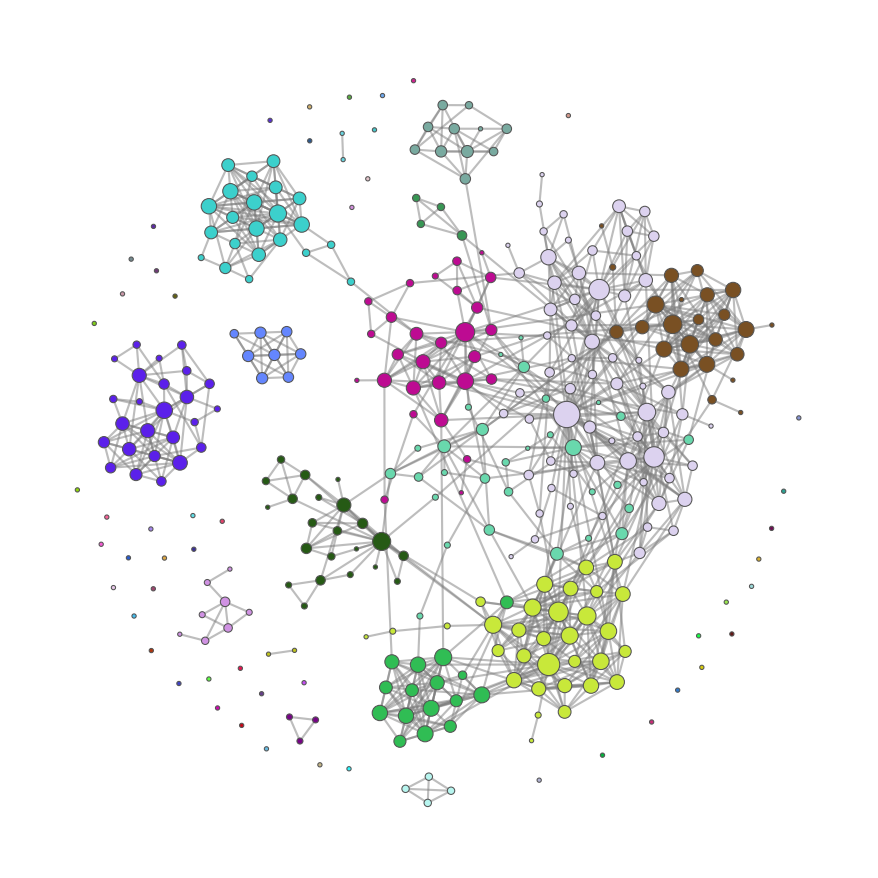

In [75]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

In [76]:
len(np.unique(list(nx.get_node_attributes(H3,'Louvain').values())))

69

To get insight into the overlap between the Louvain and the category partitioning we make a confusion matrix.

This confusion matrix shows what community the products belongs to in both the category and louvain partitions. This makes it easier to see if the louvain algorithm mimics certain categories, and which categories are the most interconnected. For example, if a category is contained almost entirely within a louvain community, it means that the category community was strongly interconnected. 

[Text(0, 0.5, 'Baby Foods'),
 Text(0, 1.5, 'Beverages'),
 Text(0, 2.5, 'Breakfast Foods'),
 Text(0, 3.5, 'Candy & Chocolate'),
 Text(0, 4.5, 'Canned'),
 Text(0, 5.5, 'Cooking & Baking'),
 Text(0, 6.5, 'Fresh Flowers & Live Indoor Plants'),
 Text(0, 7.5, 'Gourmet Gifts'),
 Text(0, 8.5, 'Snack Foods')]

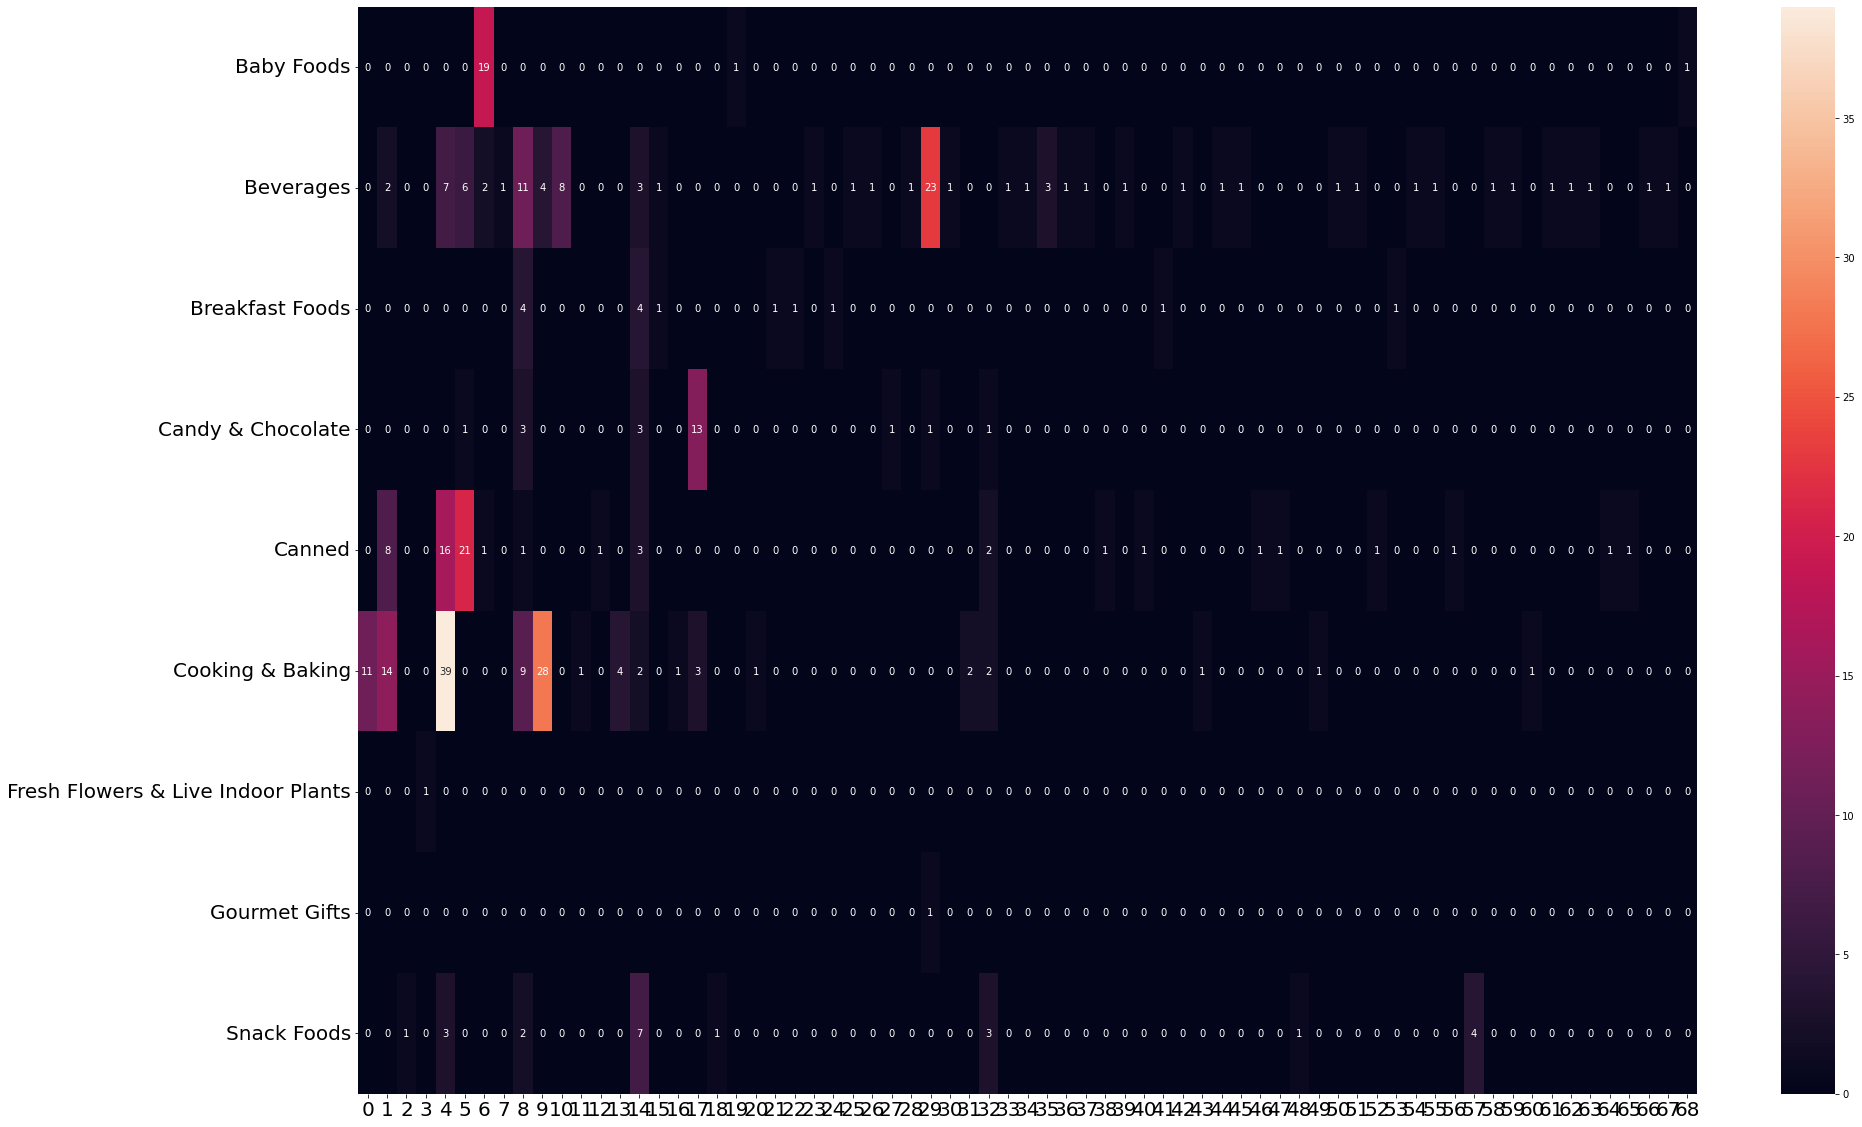

In [77]:
D = np.zeros([9,69])
cats = list(np.unique(list(nx.get_node_attributes(G3,'category').values())))
OG_dict = nx.get_node_attributes(G3, 'category')
for i in range(9):
    nodes = set([k for k in range(len(G3.nodes())) if nx.get_node_attributes(G3,'category')[list(G3.nodes())[k]] == cats[i]])
    for j in range(69):
        nodes2 = set([k for k in range(len(H3.nodes())) if nx.get_node_attributes(H3,'Louvain')[list(H3.nodes())[k]] == j])        
        D[i,j] = len(nodes2.intersection(nodes))
import seaborn as sns
plt.figure(figsize = (30,20))

ax = sns.heatmap(D, annot=True)
ax.set_xticklabels(range(69),size=20,rotation=0)
ax.set_yticklabels(np.unique(list(nx.get_node_attributes(G3,'category').values())),size=20,rotation=0)

It is hard to see what's going on in the confusion plot since there are so many bins in the Louvain split. Therefore we remove the singleton nodes and repeat the analysis to see if we find something new. Singleton nodes do not affect the modularity as they are not connected to any other notes. Therefore, we can safely remove without changing the measures.


In [78]:
G4 = G3.copy()
for node in list(G4.nodes()):
    if list(G4.edges(node)) == []:
        G4.remove_node(node)
print(len(G4.nodes()))

306


We then repeat the steps from before with the new singleton-free dataset.

In [79]:

#first compute the best partition
partition4 = community_louvain.best_partition(G4)

# number of communities in the partition
len(np.unique(list(partition4.values())))


17

In [80]:
print("modularity of category partition:", computeModularity(G4, 'category'))
H4 = G4.copy()
nx.set_node_attributes(H4, partition4, 'Louvain')

modularity = computeModularity(H4, 'Louvain')
print("The modularity of the louvain split network is:", modularity)

modularity of category partition: 0.46963262063093614
The modularity of the louvain split network is: 0.7603139083395721


In [81]:
network = nw.get_filtered_network(G4, node_group_key="category")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

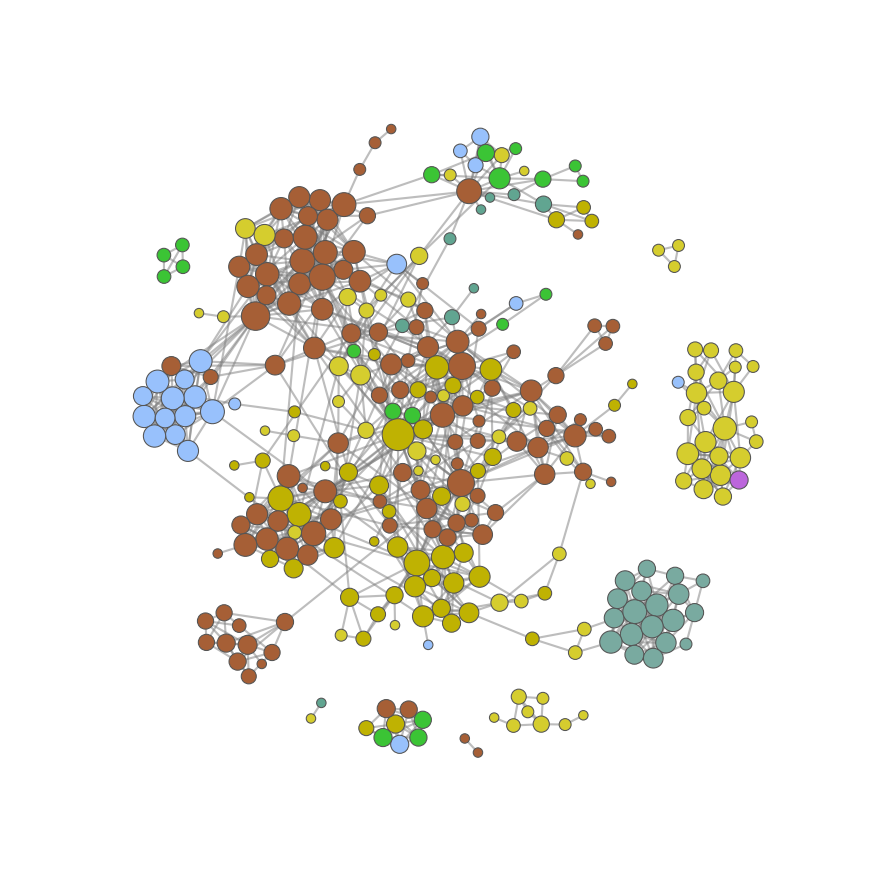

In [82]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

In [83]:
network = nw.get_filtered_network(H4, node_group_key="Louvain")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

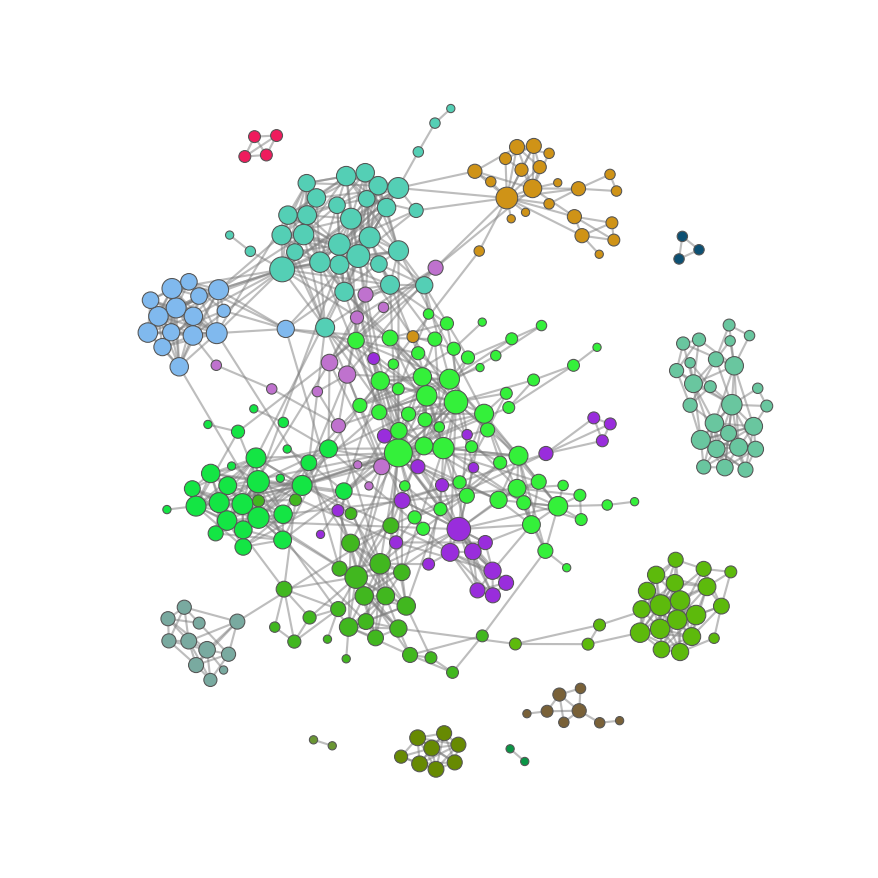

In [84]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

[Text(0, 0.5, 'Baby Foods'),
 Text(0, 1.5, 'Beverages'),
 Text(0, 2.5, 'Breakfast Foods'),
 Text(0, 3.5, 'Candy & Chocolate'),
 Text(0, 4.5, 'Canned'),
 Text(0, 5.5, 'Cooking & Baking'),
 Text(0, 6.5, 'Gourmet Gifts'),
 Text(0, 7.5, 'Snack Foods')]

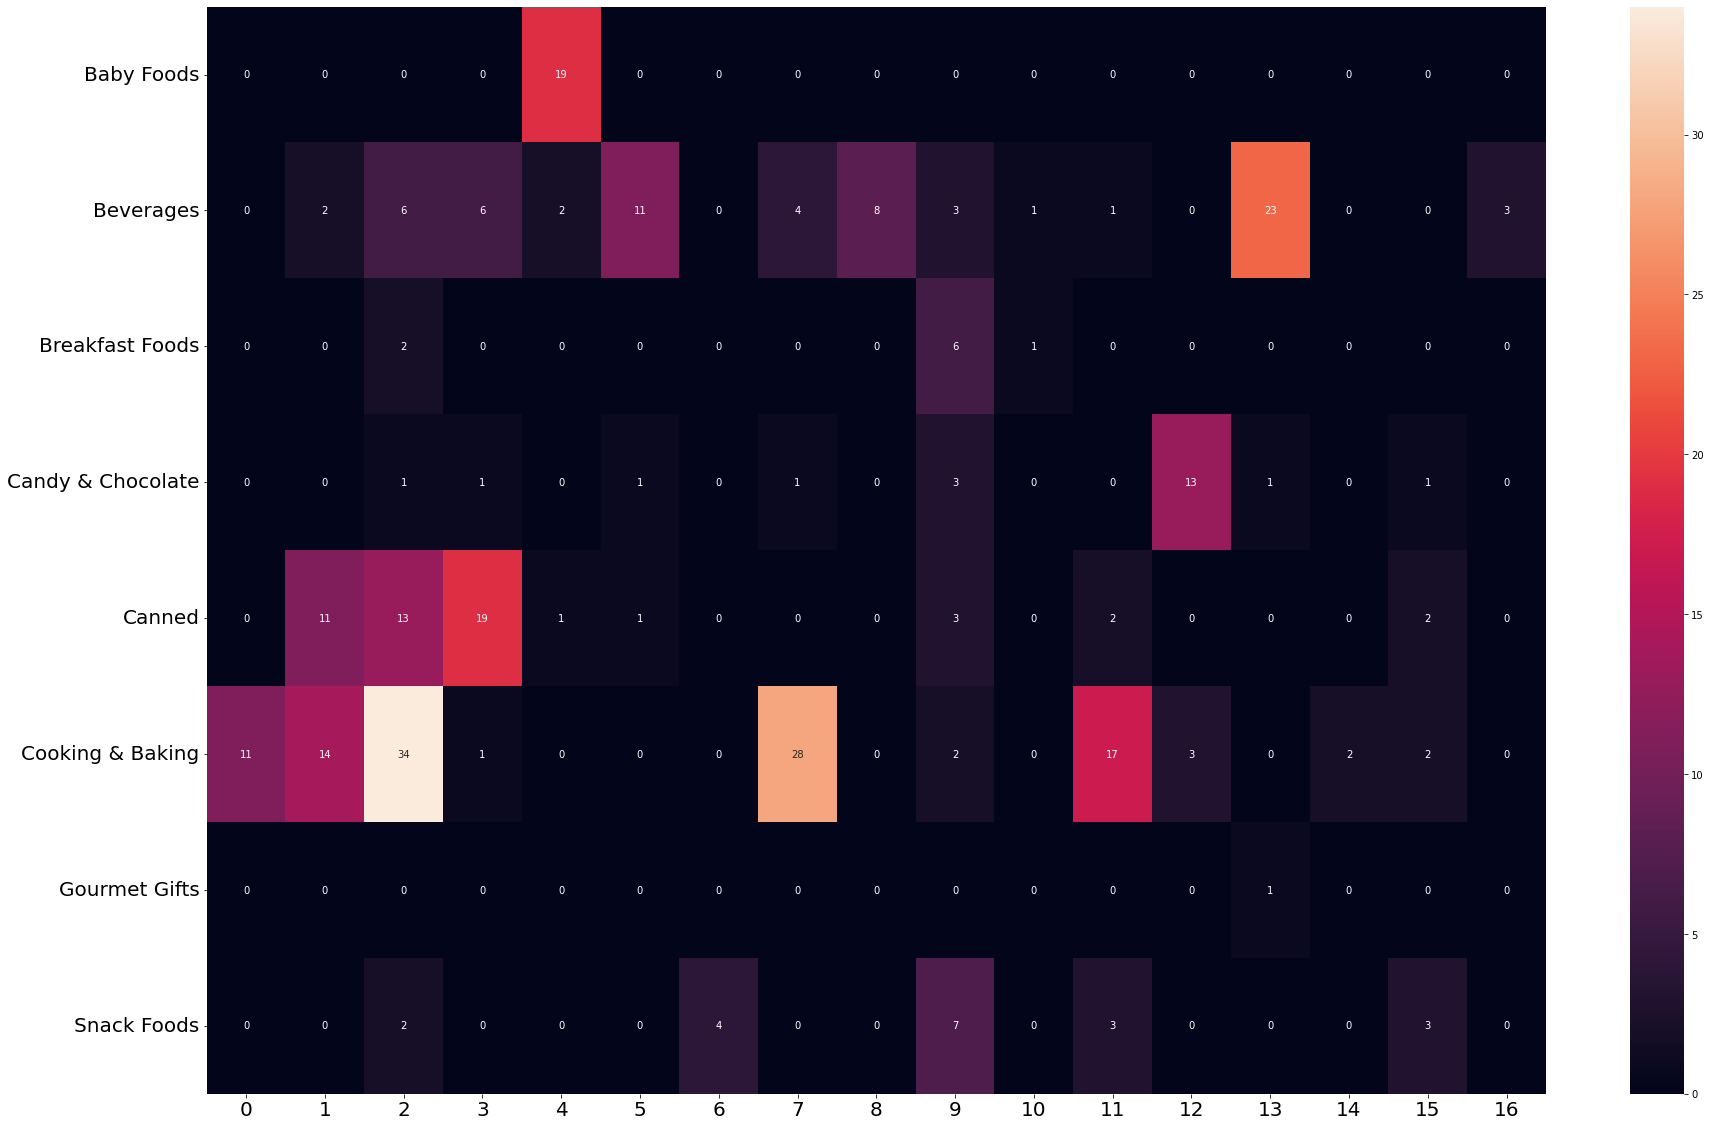

In [85]:
D = np.zeros([8,17])
cats = list(np.unique(list(nx.get_node_attributes(G4,'category').values())))
OG_dict = nx.get_node_attributes(G4, 'category')
for i in range(8):
    nodes = set([k for k in range(len(G4.nodes())) if nx.get_node_attributes(G4,'category')[list(G4.nodes())[k]] == cats[i]])
    for j in range(17):
        nodes2 = set([k for k in range(len(H4.nodes())) if nx.get_node_attributes(H4,'Louvain')[list(H4.nodes())[k]] == j])        
        D[i,j] = len(nodes2.intersection(nodes))

import seaborn as sns
plt.figure(figsize = (30,20))

ax = sns.heatmap(D, annot=True)
ax.set_xticklabels(range(17),size=20,rotation=0)
ax.set_yticklabels(np.unique(list(nx.get_node_attributes(G4,'category').values())),size=20,rotation=0)

The confusion matrix clearly shows that there are some communities in the category partition that are strongly interconnected. For example the "Baby Food" category is entirely contained within a Louvain community. Other larger categories like "Cooking & Baking" and "Beverages" are split up, which makes sense when you consider that they were bunched together in the plot.

# 4. Discussion

# 5. References


[1] http://networksciencebook.com/chapter/3#number-of-links

[2]  http://networksciencebook.com/chapter/2#clustering

[3] http://networksciencebook.com/chapter/3#clustering-3-9

[4] Our Assignment 2

[5] https://towardsdatascience.com/louvain-algorithm-93fde589f58c

[6]